In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.spatial.distance import pdist, cosine
from scipy import stats
from itertools import combinations, permutations
%matplotlib inline

np.random.seed(100)

rcParams['font.sans-serif'] = 'arial'

age_classes = ((0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 100))

birth_classes = ((2000, 2018),
                 (1974, 1999),
                 (1969, 1974),
                 (1957, 1968),
                 (1918, 1956))

def age_to_age_class(age, age_classes):
    for lb, ub in age_classes:
        if age >= lb and age <=ub:
            if lb != 65:
                ac = '-'.join((str(lb), str(ub)))
            else:
                ac = '65+'
            break
    return ac

def label_to_season(label):
    if label != '2009Pan':
        l = str(int(label) - 1) + '-' + label
    else:
        l = '2009 pandemic'
    return l

h1_seasons = ['2009', '2009Pan', '2010', '2014', '2016']
order=['2008', '2011', '2012', '2013', '2015', '2017', '2018', '2009', '2009Pan', '2010', '2014', '2016']
pal = sns.xkcd_palette(['dark sky blue', 'deep red']).as_hex()

# Age distributions

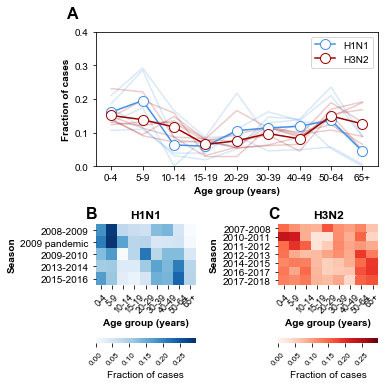

In [2]:
df = pd.read_csv('../data/standard_eligible_observed_by_age.csv')
final_df = pd.DataFrame(index=set(df.Age), columns=set(df.Season))

# gets cases of dominant subtype
for index, row in df.iterrows():
    if row.Season in h1_seasons:
        cases = row.I_obs_H1 + row.I_vac_H1

    else:
        cases = row.I_obs_H3 + row.I_vac_H3
    
    final_df.loc[row.Age, row.Season] = cases
final_df = final_df.fillna(0)
final_df['age_class'] = [age_to_age_class(a, age_classes) for a in final_df.index]
final_df = final_df.groupby('age_class').sum()

final_df = final_df.loc[[age_to_age_class(lb, age_classes) for lb, ub in age_classes], ]
cases = final_df.copy()
final_df = final_df / final_df.sum()
probabilities = final_df.copy()

final_df = final_df.transpose()
final_df = final_df.sort_index()


plt.subplot2grid((2,2), (0,0), colspan=2)
h1_cases = cases.loc[:, h1_seasons]
h3_cases = cases.loc[:, set(order) - set(h1_seasons)]

#plot individual seasons
norm_h1 = h1_cases / h1_cases.sum()
norm_h1.plot(color=pal[0], alpha=0.2, ax=plt.gca())
norm_h3 = h3_cases / h3_cases.sum()
norm_h3.plot(color=pal[1], alpha=0.2, ax=plt.gca())

t = h1_cases / h1_cases.sum()
# Plot overall case distribution
h1_cases = h1_cases / h1_cases.sum()
h3_cases = h3_cases / h3_cases.sum()
h1_cases = h1_cases.transpose().mean()
h3_cases = h3_cases.transpose().mean()

kwargs = {'markerfacecolor': 'white',
          'markersize': 10}

l_h1, =plt.plot(range(0,9), h1_cases, 'o-', markeredgecolor=pal[0], color=pal[0], label='H1N1', **kwargs)
l_h3, =plt.plot(range(0,9), h3_cases, 'o-', markeredgecolor=pal[1], color=pal[1], label='H3N2', **kwargs)
plt.xlabel('Age group (years)', weight='bold')
plt.ylabel('Fraction of cases', weight='bold')
plt.legend((l_h1, l_h3), ('H1N1', 'H3N2'))


ticks, labels = plt.xticks()
plt.xticks(range(0,10), list(cases.index), size=10)

yticks, ylabels = plt.yticks()
yticks = [round(y,2) for y in yticks]
plt.yticks(yticks, yticks, size=10)

plt.ylim(0, 0.4)
plt.xlim(-0.5, 8.5)
plt.gca().text(-0.1, 1.1, 'A', transform=plt.gca().transAxes, 
            size=16, weight='bold')

# Figure out multinomial probs

plt.subplot2grid((2,2), (1,0), colspan=1)
ax = sns.heatmap(final_df.loc[h1_seasons,],
            cmap='Blues',
            ax=plt.gca(),
            vmin=0,
            vmax=0.298,
            cbar_kws={'label':'Fraction of cases',
                      'orientation': 'horizontal',
                      'pad': 0.4},
            yticklabels=1)
ax.figure.axes[-1].tick_params(labelsize=8, rotation=45)
yticks, labels = plt.yticks()
plt.yticks(yticks, [label_to_season(l.get_text()) for l in labels], rotation=0)
plt.ylabel('Season', weight='bold')
plt.xlabel('Age group (years)', weight='bold')
plt.title('H1N1', weight='bold')
xticks, labels = plt.xticks()
plt.xticks(xticks, labels, rotation=45, size=9)
plt.gca().text(-0.1, 1.1, 'B', transform=plt.gca().transAxes, 
            size=16, weight='bold')

plt.subplot2grid((2,2), (1,1), colspan=1)
ax = sns.heatmap(final_df.loc[sorted(list(set(final_df.index) - set(h1_seasons))),],
                cmap='Reds',
                ax=plt.gca(),
                vmin=0,
                vmax=0.298,
                cbar_kws={'label':'Fraction of cases',
                          'orientation': 'horizontal',
                          'pad': 0.4},
                yticklabels=1)

ax.figure.axes[-1].tick_params(labelsize=8, rotation=45)
yticks, labels = plt.yticks()
plt.yticks(yticks, [label_to_season(l.get_text()) for l in labels], rotation=0)
plt.xlabel('Age group (years)', weight='bold')
plt.title('H3N2', weight='bold')
plt.ylabel('Season', weight='bold')
xticks, labels = plt.xticks()
plt.xticks(xticks, labels, rotation=45, size=9)
plt.gca().text(-0.1, 1.1, 'C', transform=plt.gca().transAxes, 
            size=16, weight='bold')

plt.gcf().set_size_inches(5.5, 5.5)
plt.tight_layout()

# Evaluating age distribution significance

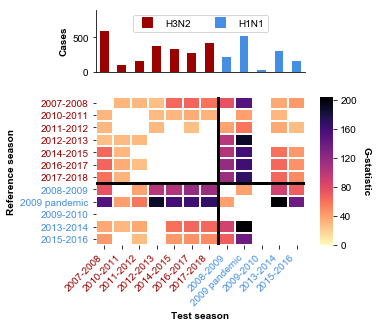

In [3]:
dist_df = pd.DataFrame(0, columns=probabilities.columns, index=probabilities.columns)
num_comparisons = len(cases.columns) * (len(cases.columns) - 1) / 2
for s1, s2 in combinations(cases.columns, 2):
    d1 = cases[s1]
    d2 = cases[s2]
    g, p, dof, e = stats.chi2_contingency([d1, d2], lambda_="log-likelihood")
    if p * num_comparisons < 0.05:
        first, second = sorted([s1, s2])
        
        dist_df.loc[s1, s2] = g
        dist_df.loc[s2, s1] = g
        #dist_df.loc[first, second] = g
dist_df = dist_df.loc[order, order]
ncol = 9
cmap = plt.get_cmap('magma_r')
cmap.set_under(color='white')

# Set colorbar axis
cbar_ax = plt.subplot2grid((3,ncol), (1,ncol-1), colspan=1, rowspan=2)

# Plot case sums
plt.subplot2grid((3,ncol),(0,0), rowspan=1, colspan=ncol - 1)
case_sums = cases.sum()[order]
case_sums.plot.bar(color=[pal[1]] * 7 + [pal[0]] * 5)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

l_h1, = plt.plot([100, 100], [100, 100], 's', color=pal[0], markersize=10, label='H1N1')
l_h3, = plt.plot([100, 100], [100, 100], 's', color=pal[1], markersize=10, label='H3N2')

plt.xticks([])
plt.xlim(xmin, xmax)
plt.ylim(ymin, 900)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend((l_h3, l_h1), ('H3N2', 'H1N1'), ncol=2, loc='upper center')
plt.ylabel('Cases', weight='bold')

plt.subplot2grid((3,ncol),(1,0),rowspan=2, colspan=ncol-1)
sns.heatmap(dist_df,
            cmap=cmap,
            cbar=True,
            cbar_ax=cbar_ax,
            vmin=0.001,
            linewidth=1)

plt.ylabel('Reference season', weight='bold')
plt.xlabel('Test season', weight='bold')

for xtick in plt.gca().get_xticklabels():
    if xtick.get_text() in h1_seasons:
        xtick.set_color(pal[0])
    else:
        xtick.set_color(pal[1])

for ytick in plt.gca().get_yticklabels():
    if ytick.get_text() in h1_seasons:
        ytick.set_color(pal[0])
    else:
        ytick.set_color(pal[1])
        
yticks, labels = plt.yticks()
plt.yticks(yticks, [label_to_season(l.get_text()) for l in labels], rotation=0)

xticks, labels = plt.xticks()
plt.xticks(xticks, [label_to_season(l.get_text()) for l in labels], rotation=45, ha='right')
plt.gca().axvline(x=7, color='black',linewidth=3)
plt.gca().axhline(y=7, color='black',linewidth=3)
cbar_ax.set_ylabel('G-statistic', rotation=270, va='bottom', weight='bold')
plt.tight_layout()
plt.gcf().set_size_inches(5,5)

# Relative risk by age group

C:\Users\parevalo\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\parevalo\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


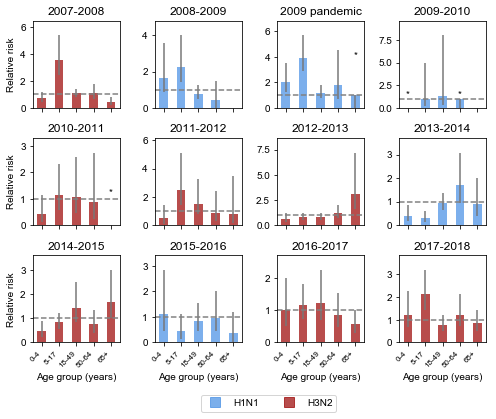

In [4]:
age_classes = ((0, 4),
               (5, 17),
               (18, 49),
               (50, 64),
               (65, 100))

raw_data = pd.read_csv('../raw_data/cases_of_dominant_subtype_by_age.csv')
raw_data['age_class'] = [age_to_age_class(a, age_classes) for a in raw_data.Age]
rr_rows = []
subplot = 1
pal = sns.xkcd_palette(['dark sky blue', 'light sky blue', 'deep red']).as_hex()
for season, seasondf in raw_data.groupby('Season'):
    plt.subplot(3,4,subplot)
    
    new_rows = []
    for ag in [age_to_age_class(a, age_classes) for a, a2 in age_classes]:
        agdf = seasondf[seasondf.age_class == ag].copy()

        pre_med = agdf[agdf.Season_section == 'Start'].sum().Count

        post_med = agdf[agdf.Season_section == 'End'].sum().Count
        ag_all = pre_med + post_med
        if post_med != 0:
            RR = (pre_med/post_med)
            if pre_med != 0:
                l, h = stats.binom.interval(0.95, ag_all, pre_med/ag_all)
            else:
                l = 0
                h = 0
            
            if ag_all - l == 0:
                low = 0
            else:
                low = l / (ag_all - l)
            if ag_all - h == 0:
                high = RR
            else:
                high = h / (ag_all - h)
            
            new_rows.append([ag, RR, low, high])
            rr_rows.append([season, ag, RR])
        elif pre_med == 0:
            new_rows.append([ag, 0, 0, 0])
            rr_rows.append([season, ag, 0])
        else:
            new_rows.append([ag, np.nan, np.nan, np.nan])
            rr_rows.append([season, ag, np.nan])
    plotdf = pd.DataFrame(new_rows, columns=['Age group', 'Relative risk', 'Relative risk CI low', 'Relative risk CI high'])
    plotdf.index = plotdf['Age group']
    plotdf = plotdf.loc[[age_to_age_class(a, age_classes) for a, a2 in age_classes], ]
    maxrr = np.nanmax(list(plotdf['Relative risk']))
    position = 0
    
    for index, row in plotdf.iterrows():
        if np.isnan(row['Relative risk']) or (row['Relative risk'] ==  row['Relative risk CI high'] and row['Relative risk'] != 0):
            plt.text(position, maxrr, '*', ha='center', size=10)
        position += 1
    #plotdf = plotdf.fillna(maxrr)
    
    if season in ['2009', '2009Pan', '2010', '2014', '2016']:
        subtype_col = pal[0]
    else:
        subtype_col = pal[2]
    
    plotdf.plot.bar(x='Age group', y='Relative risk', color=subtype_col, legend=False, label='', ax=plt.gca(), alpha=0.7)
    
    plt.vlines(x=range(0, 9), ymin=plotdf['Relative risk CI low'], ymax=plotdf['Relative risk CI high'], color='#777777')
    plt.ylabel('Relative risk')
    plt.axhline(1.0, linestyle='--', color='grey')

    if subplot in [1, 5, 9]:
        plt.ylabel('Relative risk')
    else:
        plt.ylabel('')
    if subplot in [9, 10, 11, 12]:
        plt.xlabel('Age group (years)')
        ticks, labels = plt.xticks()
        plt.xticks(ticks, labels, rotation=45, ha='right', size=8)
    else:
        plt.xlabel('')
        ticks, labels = plt.xticks()
        plt.xticks(ticks,[])
    if season != '2009Pan':
        plt.title(str(int(season) -1) + '-' + season)
    else:
        plt.title('2009 pandemic')
    plt.ylim(0, np.max(plotdf['Relative risk CI high']) * 1.2)
    subplot += 1
plt.gcf().set_size_inches(7, 5.5)
plt.tight_layout()
plt.gcf().align_labels()

l_h1, = plt.plot([100, 100], [100, 100], 's', color=pal[0], markersize=10, label='H1N1', alpha=0.7)
l_h3, = plt.plot([100, 100], [100, 100], 's', color=pal[2], markersize=10, label='H3N2', alpha=0.7)
plt.legend(ncol=2, loc='center', bbox_to_anchor=(-1.5, -0.7))

rr_all = pd.DataFrame(rr_rows, columns = ['Season', 'Age group', 'RR'])

# Plotting relative risk vs. fraction cases

In [5]:
# First, process simulation data to calculate relative risk. Simulated data are not included in the repository, but
# the simulation code is available under /simulations/

rhos = []
for t in range(0, 1000):
    f = '../simulations/simulated_data/simulation_by_age_%s.csv'%t
    sim = pd.read_csv(f)
    sim['age_class'] = [age_to_age_class(a, age_classes) for a in sim.Age]
    new_rows = []
    for season, seasondf in sim.groupby('Season'):
        total_cases = seasondf.sum().Count
        for ag in [age_to_age_class(a, age_classes) for a, a2 in age_classes]:
            agdf = seasondf[seasondf.age_class == ag].copy()
            agcases = agdf.sum().Count
            frac_cases = agcases/total_cases
            pre_med = agdf[agdf.Season_section == 'Start'].sum().Count
            post_med = agdf[agdf.Season_section == 'End'].sum().Count
            ag_all = pre_med + post_med
            if post_med != 0:
                RR = (pre_med/post_med)
                new_rows.append([season, ag, RR, frac_cases])
            elif pre_med == 0 and post_med != 0:
                new_rows.append([season, ag, 0, frac_cases])
            else:
                new_rows.append([season, ag, np.nan, frac_cases])

    plotdf = pd.DataFrame(new_rows, columns=['Season', 'Age group', 'RR', 'Fraction of cases'])
    plotdf = plotdf.dropna()
    r, p = stats.spearmanr(plotdf.RR, plotdf['Fraction of cases'])
    rhos.append(r)


0.47181031982046906 0.02303046320492312
0.34558374083129584 0.04529921006609827
0.4102726259972405 0.0015260989448009775


Text(-0.1, 1.1, 'B')

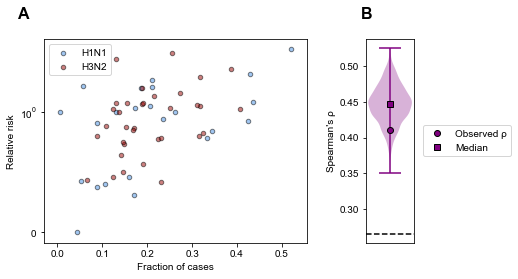

In [7]:
pal = sns.xkcd_palette(['dark sky blue', 'deep red']).as_hex()
total_cases = pd.read_csv('../data/standard_eligible_observed_by_age.csv')
total_cases['Age'] = [age_to_age_class(a, age_classes) for a in total_cases.Age]
total_cases = total_cases.groupby(['Season', 'Age']).sum().reset_index()
total_cases['H1'] = total_cases.I_vac_H1 + total_cases.I_obs_H1
total_cases['H3'] = total_cases.I_vac_H3 + total_cases.I_obs_H3
case_rows = []

plt.subplot2grid((1, 4), (0, 0), colspan=3)

for season, seasondf in total_cases.groupby('Season'):
    temp = seasondf.copy()
    if season in ['2009', '2009Pan', '2010', '2014', '2016']:
        temp['dist'] = temp.H1 / temp.sum().H1
        for index, row in temp.iterrows():
            case_rows.append([season, row.Age, row.dist])

case_df = pd.DataFrame(case_rows, columns = ['Season', 'Age group', 'Fraction of cases'])
#case_df = case_df.groupby(['Season', 'Age_group'])

rcParams['font.sans-serif'] = 'arial'
plotdf = case_df.merge(rr_all, how='outer')
plotdf = plotdf.dropna().copy()
plotdf.plot.scatter(x='Fraction of cases', y='RR', edgecolor='black', color=pal[0], alpha=0.5, ax=plt.gca(), label='H1N1')
rho, pval = stats.spearmanr(plotdf['Fraction of cases'], plotdf['RR'])
print(rho, pval)
case_rows = []
for season, seasondf in total_cases.groupby('Season'):
    temp = seasondf.copy()
    if season not in ['2009', '2009Pan', '2010', '2014', '2016']:
        temp['dist'] = temp.H3 / temp.sum().H3
        for index, row in temp.iterrows():
            case_rows.append([season, row.Age, row.dist])

case_df = pd.DataFrame(case_rows, columns = ['Season', 'Age group', 'Fraction of cases'])

rcParams['font.sans-serif'] = 'arial'
plotdf = case_df.merge(rr_all, how='outer')
plotdf = plotdf.dropna().copy()
plotdf.plot.scatter(x='Fraction of cases', y='RR', edgecolor='black', color=pal[1], alpha=0.5, ax=plt.gca(), label='H3N2')

plt.ylabel('Relative risk')
plt.yscale('symlog', linthreshy=1)
rho, pval = stats.spearmanr(plotdf['Fraction of cases'], plotdf['RR'])
print(rho, pval)
plt.gca().text(-0.1, 1.1, 'A', transform=plt.gca().transAxes, size=16, weight='bold')



case_rows = []
for season, seasondf in total_cases.groupby('Season'):
    temp = seasondf.copy()
    if season not in ['2009', '2009Pan', '2010', '2014', '2016']:
        temp['dist'] = temp.H3 / temp.sum().H3
    else:
        temp['dist'] = temp.H1 / temp.sum().H1
    for index, row in temp.iterrows():
        case_rows.append([season, row.Age, row.dist])

case_df = pd.DataFrame(case_rows, columns = ['Season', 'Age group', 'Fraction of cases'])
plotdf = case_df.merge(rr_all, how='outer')
plotdf = plotdf.dropna().copy()
rho, pval = stats.spearmanr(plotdf['Fraction of cases'], plotdf['RR'])
print(rho, pval)
# Analyze simulated data
plt.ylabel('Relative risk')
plt.yscale('symlog', linthreshy=1)
rho, pval = stats.spearmanr(plotdf['Fraction of cases'], plotdf['RR'])

plt.subplot2grid((1, 4), (0, 3), colspan=1)
sns.set_palette(['purple'])
plt.violinplot(rhos)
plt.xticks([], [])
plt.ylabel("Spearman's ρ")
plt.plot([1], [rho], 'o', markeredgecolor='black', label='Observed ρ')
plt.plot([1], [np.median(rhos)], 's', markeredgecolor='black', label='Median')
plt.plot([])
plt.tight_layout()
plt.legend(loc='center', bbox_to_anchor=(2.1, 0.5))
plt.axhline(0.265, color='black', linestyle='--')
plt.gca().text(-0.1, 1.1, 'B', transform=plt.gca().transAxes, size=16, weight='bold')